In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

sys.path.append(os.path.abspath("../src"))

In [11]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from random_forest import RandomForest

## Utility functions

In [ ]:
def sample_paths_stats(forest, X, feature_names=None):
    path_lengths = []
    num_features = []

    for x in X:
        all_paths = forest._trace_paths(x, feature_names=feature_names)  # returns [(tree_idx, steps), ...]
        # all_paths: list of tuples like (tree_idx, steps) where steps is list of dicts
        lengths = [len(steps) for (_tidx, steps) in all_paths]
        path_lengths.append(np.mean(lengths))

        # features used (unique) across trees for this sample
        used = set()
        for (_tidx, steps) in all_paths:
            for step in steps:
                feat = step.get("feature", None)
                if feat is None:
                    feat = step.get("feature_idx", None)
                used.add(feat)
        num_features.append(len(used))

    return float(np.mean(path_lengths)), float(np.mean(num_features))

def evaluate_config(X_train, X_val, y_train, y_val, n_trees, max_depth, seed=0, feature_names=None):
    t0 = time.time()
    forest = RandomForest(n_trees=n_trees, max_depth=max_depth, random_state=seed)
    forest.fit(X_train, y_train)
    train_time = time.time() - t0

    t1 = time.time()
    y_pred = forest.predict(X_val)
    predict_time = time.time() - t1

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')

    # compute explainability complexity measures on a small subset for speed
    subset_idx = np.random.RandomState(seed).choice(len(X_val), min(100, len(X_val)), replace=False)
    X_sub = X_val[subset_idx]
    avg_path_len, avg_num_feats = sample_paths_stats(forest, X_sub, feature_names=feature_names)

    return {
        "n_trees": n_trees,
        "max_depth": max_depth,
        "seed": seed,
        "accuracy": acc,
        "f1": f1,
        "train_time": train_time,
        "predict_time": predict_time,
        "avg_path_len": avg_path_len,
        "avg_num_feats": avg_num_feats
    }

def run_grid_search(X, y, feature_names=None):
    n_trees_list = [3, 5, 8, 10, 20]
    max_depth_list = [3, 4, 5]
    seeds = [1, 2, 3] # 4, 5, 6, 7, 8, 9, 10 # repeat for stability

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    results = []
    for n in n_trees_list:
        for d in max_depth_list:
            for s in seeds:
                res = evaluate_config(X_train, X_val, y_train, y_val, n, d, seed=s, feature_names=feature_names)
                results.append(res)
                print(f"Done n={n} d={d} s={s} acc={res['accuracy']:.3f} path_len={res['avg_path_len']:.2f}")
    return results, n_trees_list, max_depth_list

def create_accuracy_heatmap(results):
    df = pd.DataFrame(results)
    pivot = df.groupby(['n_trees','max_depth'])['accuracy'].mean().unstack()
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("Validation Accuracy (average over 10 seeds)")
    plt.xlabel("max_depth")
    plt.ylabel("n_trees")
    plt.show()

def plot_accuracy_vs_complexity(results):
    df = pd.DataFrame(results)
    agg = df.groupby(['n_trees','max_depth']).mean().reset_index()

    # Distinct categorical colors for n_trees
    unique_trees = sorted(agg['n_trees'].unique())
    cmap = plt.get_cmap("tab10")  # up to 10 distinct colors
    color_map = {n: cmap(i % 10) for i, n in enumerate(unique_trees)}

    # Different marker shapes for max_depth
    markers = ['o', 's', '^', 'D', 'P', '*']
    unique_depths = sorted(agg['max_depth'].unique())
    marker_map = {d: markers[i % len(markers)] for i, d in enumerate(unique_depths)}

    plt.figure(figsize=(8,6))

    for _, row in agg.iterrows():
        plt.scatter(
            row['avg_path_len'], row['accuracy'],
            color=color_map[row['n_trees']],
            marker=marker_map[row['max_depth']],
            s=100, edgecolor="black", alpha=0.8
        )

    # Build custom legends
    tree_handles = [plt.Line2D([0],[0], marker='o', color='w', label=f"{n} trees",
                               markerfacecolor=color_map[n], markersize=10, markeredgecolor="black")
                    for n in unique_trees]

    depth_handles = [plt.Line2D([0],[0], marker=marker_map[d], color='w', label=f"depth {d}",
                                markerfacecolor="gray", markersize=10, markeredgecolor="black")
                     for d in unique_depths]

    plt.legend(handles=tree_handles + depth_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Avg path length (explainability complexity)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Explanation Complexity")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## Wine

Done n=3 d=3 s=1 acc=0.944 path_len=2.61
Done n=3 d=3 s=2 acc=0.917 path_len=2.43
Done n=3 d=3 s=3 acc=0.972 path_len=2.48
Done n=3 d=4 s=1 acc=0.972 path_len=2.74
Done n=3 d=4 s=2 acc=0.972 path_len=2.49
Done n=3 d=4 s=3 acc=0.889 path_len=2.77
Done n=3 d=5 s=1 acc=1.000 path_len=2.87
Done n=3 d=5 s=2 acc=0.972 path_len=2.49
Done n=3 d=5 s=3 acc=0.889 path_len=2.94
Done n=5 d=3 s=1 acc=0.972 path_len=2.60
Done n=5 d=3 s=2 acc=0.972 path_len=2.34
Done n=5 d=3 s=3 acc=0.944 path_len=2.58
Done n=5 d=4 s=1 acc=1.000 path_len=2.62
Done n=5 d=4 s=2 acc=1.000 path_len=2.52
Done n=5 d=4 s=3 acc=0.972 path_len=2.73
Done n=5 d=5 s=1 acc=0.944 path_len=2.76
Done n=5 d=5 s=2 acc=1.000 path_len=2.52
Done n=5 d=5 s=3 acc=0.917 path_len=2.98
Done n=8 d=3 s=1 acc=0.972 path_len=2.57
Done n=8 d=3 s=2 acc=0.972 path_len=2.45
Done n=8 d=3 s=3 acc=0.972 path_len=2.61
Done n=8 d=4 s=1 acc=1.000 path_len=2.59
Done n=8 d=4 s=2 acc=1.000 path_len=2.50
Done n=8 d=4 s=3 acc=0.944 path_len=2.78
Done n=8 d=5 s=1

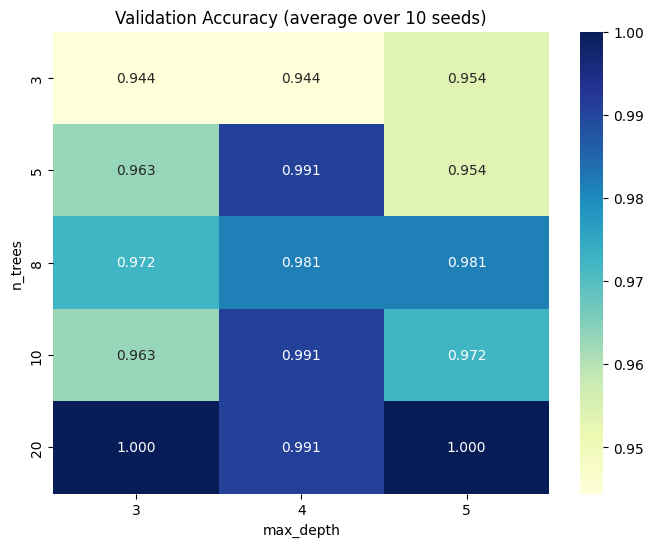

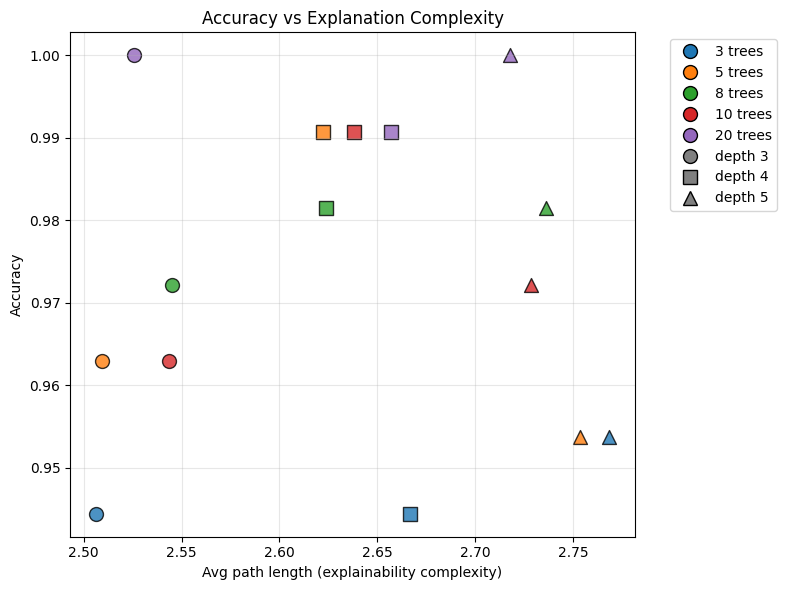

In [ ]:
data = load_wine()
X, y = data.data, data.target
feature_names = list(data.feature_names)
results, n_trees_list, max_depth_list = run_grid_search(X, y, feature_names=feature_names)
create_accuracy_heatmap(results)
plot_accuracy_vs_complexity(results)

## Breast cancer

Done n=3 d=3 s=1 acc=0.956 path_len=2.99
Done n=3 d=3 s=2 acc=0.939 path_len=2.89
Done n=3 d=3 s=3 acc=0.947 path_len=2.89
Done n=3 d=3 s=4 acc=0.939 path_len=2.79
Done n=3 d=3 s=5 acc=0.939 path_len=3.00
Done n=3 d=4 s=1 acc=0.939 path_len=3.69
Done n=3 d=4 s=2 acc=0.956 path_len=3.55
Done n=3 d=4 s=3 acc=0.956 path_len=3.80
Done n=3 d=4 s=4 acc=0.921 path_len=3.69
Done n=3 d=4 s=5 acc=0.904 path_len=3.66
Done n=3 d=5 s=1 acc=0.939 path_len=3.80
Done n=3 d=5 s=2 acc=0.930 path_len=3.86
Done n=3 d=5 s=3 acc=0.947 path_len=4.12
Done n=3 d=5 s=4 acc=0.947 path_len=4.09
Done n=3 d=5 s=5 acc=0.939 path_len=4.24
Done n=3 d=6 s=1 acc=0.930 path_len=4.37
Done n=3 d=6 s=2 acc=0.939 path_len=4.37
Done n=3 d=6 s=3 acc=0.930 path_len=4.25
Done n=3 d=6 s=4 acc=0.939 path_len=4.49
Done n=3 d=6 s=5 acc=0.930 path_len=5.05
Done n=3 d=8 s=1 acc=0.939 path_len=4.40
Done n=3 d=8 s=2 acc=0.956 path_len=4.20
Done n=3 d=8 s=3 acc=0.956 path_len=4.48
Done n=3 d=8 s=4 acc=0.912 path_len=4.23
Done n=3 d=8 s=5

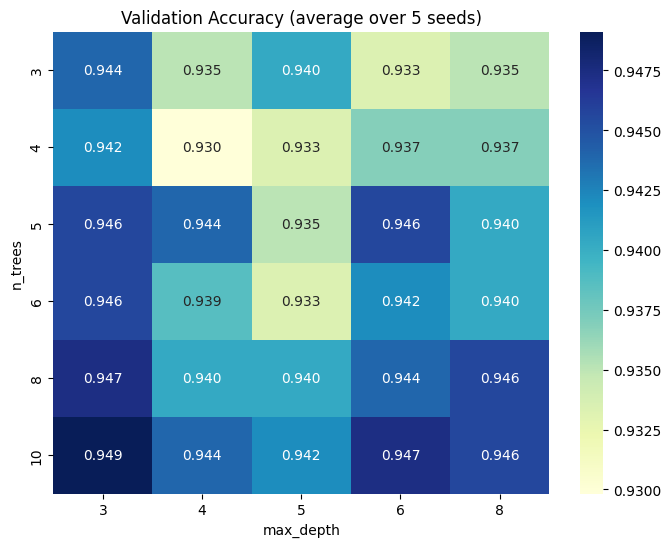

KeyError: 'complexity'

In [ ]:
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = list(data.feature_names)
results, n_trees_list, max_depth_list = run_grid_search(X, y, feature_names=feature_names)
create_accuracy_heatmap(results)
plot_accuracy_vs_complexity(results)